# Hyperparams and Helpers

In [2]:
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
!gunzip GoogleNews-vectors-negative300.bin.gz

--2021-10-31 20:14:06--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.207.72
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.207.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  45.9MB/s    in 35s     

2021-10-31 20:14:41 (45.3 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [3]:
import cv2
import numpy as np
import pickle
import os
import itertools
import tqdm
from PIL import Image

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from gensim.models import KeyedVectors
import random
from sklearn.model_selection import train_test_split
# random.seed(517)

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [30]:
# Global Path Vairables
ROOT_DIR =  "drive/MyDrive/DecorAssist/"
DATASET_DIR = ROOT_DIR + "IKEA/text_data/"
IMAGES_DIR = ROOT_DIR + "IKEA/images/all_items/"

# Global Parameter Variables
MAX_SEQUENCE_LENGTH = 100
NUM_WORDS_TOKENIZER = 50000
EMBEDDING_DIM = 300
BATCH_SIZE = 32
POSITIVE_SIZE = 1000 # We might only use a subset of the positive pairs
TRAIN_TEST_RATIO = 0.33

# Model Hyperparameters
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LEARNING_RATE = 2e-5 # 0.001
HIDDEN_DIM = 64 # 64
N_LAYERS = 8 # 2
EPOCHS = 5
CLIP = 5
DROPOUT = 0.1

In [5]:
def preprocess_img(path):
  img = cv2.imread(path)
  try:
    img = cv2.resize(img, (75, 115))
  except:
    print(path)
  img = img.astype(np.float32) / 255
  img = np.reshape(img, (3, 75 ,115))
  return img


def read_pickle(fn):
	with open(fn, "rb") as f:
		return pickle.load(f)


# Train-val split that does not share products between training and validation sets.
def generate_product_limited_samples(products, all_positive_pairs, random_state=None):
    """
    Generates positive and negative examples for the given products using shared
    occurence in rooms to indicate whether two products are compatible.

    products: A sequence of product IDs; ALL positive and negative pairs must
        contain only these product IDs.
    all_positive_pairs: A set of product ID pairs that are positive.
    
    Returns: A tuple (x, y), where x is a sequence of product ID pairs and y is
        the array of [0 or 1] labels indicating presence in all_positive_pairs.
    """
    product_set = set(products)
    within_positive_pairs = [p for p in sorted(all_positive_pairs) if p[0] in product_set and p[1] in product_set]
    negative_pairs = random_negative_sampling(products, all_positive_pairs, count=len(within_positive_pairs), random_state=random_state)
    x = within_positive_pairs + negative_pairs
    y = np.array([1] * len(within_positive_pairs) + [0] * len(negative_pairs))
    if random_state is not None: np.random.seed(random_state)
    indices = np.random.permutation(np.arange(len(x)))
    return [x[i] for i in indices], y[indices]


def random_negative_sampling(products, all_positive_pairs, count=None, random_state=None):
  selected_negative_pairs = []
  if random_state is not None: random.seed(random_state)
  while len(selected_negative_pairs) < (count or len(all_positive_pairs)):
    random_pair = tuple(random.sample(products, 2))
    if random_pair in all_positive_pairs:
      continue
    else:
      selected_negative_pairs.append(random_pair)
  return selected_negative_pairs


def get_embedding_matrix(word_index, weights_path="/content/GoogleNews-vectors-negative300.bin"):
  word2vecDict = KeyedVectors.load_word2vec_format(weights_path, binary=True)
  embed_size = 300
  embeddings_index = dict()
  for word in word2vecDict.wv.vocab:
    embeddings_index[word] = word2vecDict.word_vec(word)
  print("Loaded " + str(len(embeddings_index)) + " word vectors.")
        
  embedding_matrix = 1 * np.random.randn(len(word_index)+1, embed_size)

  embeddedCount = 0
  for word, i in word_index.items():
    i-=1
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
      embedding_matrix[i] = embedding_vector
      embeddedCount+=1
  print("total embedded:", embeddedCount, "common words")
  del(embeddings_index)
  return embedding_matrix

# Build Train and Eval Set

#### Load raw data

In [6]:
# {room image url -> string of room category}; e.g.: 'ikea-town-and-country__1364308377063-s4.jpg': 'Living Room'
room_categories = read_pickle(DATASET_DIR + "categories_dict.p")
# {item image ID -> string of item category}; e.g.: '291.292.29': 'Footstool',
item_categories = read_pickle(DATASET_DIR + "categories_images_dict.p")
# {item image id -> dict of descriptions}; e.g. '202.049.06': {'color': 'Grey,black','desc': 'View more product information Concealed press studs keep the quilt in place','img': 'images/objects/202.049.06.jpg','name': 'GURLI','size': '120x180 cm','type': 'Throw'},
item_property = read_pickle(DATASET_DIR + "products_dict.p")
# {item image url -> {description, name}}; e.g: '/static/images/902.592.50.jpg': {'desc': 'The high pile dampens sound and provides a soft surface to walk on.','name': 'GSER'},
item_to_description = read_pickle(DATASET_DIR + "img_to_desc.p")
# {item image url -> list of corresponding room image url}; e.g.: 'images/001.509.85.jpg': ['images/room_scenes/ikea-wake-up-and-grow__1364335362013-s4.jpg','images/room_scenes/ikea-wake-up-and-grow-1364335370196.jpg'],
item_to_rooms_map = read_pickle(DATASET_DIR + "item_to_room.p")
# {room image url -> list of items}; e.g.: 'ikea-work-from-home-in-perfect-harmony__1364319311386-s4.jpg': ['desk','chair']
room_to_item_categories = read_pickle(DATASET_DIR + "room_to_items.p")

# Some simple preprossing
item_to_info = {key : value["type"] + " " +
                             value["desc"]
                       for key, value in item_property.items()} # remove view more info

room_to_items = {}

for item_url, room_url_list in item_to_rooms_map.items():
  item_id = item_url.split("/")[-1].split(".jpg")[0]
  if not os.path.exists(IMAGES_DIR + item_id + ".jpg"):
      print(item_url + " does not exist")
      continue

  for room_url in room_url_list:
    room_id = room_url.split("/")[-1].split(".jpg")[0]
    if room_id not in room_to_items:
      room_to_items[room_id] = [item_id]
    else:
      room_to_items[room_id].append(item_id)

images/890.333.75.jpg does not exist
images/991.333.98.jpg does not exist
images/990.612.97.jpg does not exist


#### Construct positive and negative pairs

For IR-style problem, seen and unseen can be tricky. We need to discuss whether unseen means "unseen pairs" or "unseen image or text"

In [7]:
all_positive_pairs = set()
for room, item_id_list in room_to_items.items():
  pairs_for_current_room = list(itertools.combinations(room_to_items[room], 2)) # n choose 2
  all_positive_pairs |= set(pairs_for_current_room)

all_products = sorted(set([x for pair in all_positive_pairs for x in pair]))
train_products, val_products = train_test_split(all_products, test_size=TRAIN_TEST_RATIO, random_state=72)

train_pairs, y_train = generate_product_limited_samples(train_products, all_positive_pairs, random_state=72)
val_pairs, y_val = generate_product_limited_samples(val_products, all_positive_pairs, random_state=72)
print(len(train_pairs), len(val_pairs))

# with open(ROOT_DIR + "train_data.pkl", "wb") as file:
#     pickle.dump((train_pairs, y_train), file)
# with open(ROOT_DIR + "val_data.pkl", "wb") as file:
#     pickle.dump((val_pairs, y_val), file)

21666 5810


In [8]:
# # To read the training and validation sets
# with open(ROOT_DIR + "train_data.pkl", "rb") as file:
#     train_pairs, y_train = pickle.load(file)
# with open(ROOT_DIR + "val_data.pkl", "rb") as file:
#     val_pairs, y_val = pickle.load(file)

#### Build PyTorch dataloader for train/val image/text

In [9]:
class FurnitureImagePairsDataset(Dataset):
    """Dataset containing pairs of furniture items."""

    def __init__(self, image_path, pairs, labels):
        """
        Args:
            image_path (string): Path to the directory containing images.
            pairs (list of tuples of strings): Pairs of image IDs to be used as training samples.
            labels (array of integers): Labels for the training samples.
        """
        super(FurnitureImagePairsDataset, self).__init__()
        self.image_ids = list(set(x for pair in pairs for x in pair))
        self.index_mapping = {image_id: i for i, image_id in enumerate(self.image_ids)}
        self.images = [preprocess_img(image_path + image_id + ".jpg") for image_id in tqdm.tqdm(self.image_ids)]
        self.pairs = pairs
        self.labels = labels

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        if isinstance(idx, (list, tuple)):
            x1, x2, y = zip(*[self[i] for i in idx])
            return torch.stack(x1), torch.stack(x2), torch.from_numpy(np.array(y))
        pair = self.pairs[idx]
        return self.images[self.index_mapping[pair[0]]], self.images[self.index_mapping[pair[1]]], self.labels[idx]

In [10]:
X_train_image = FurnitureImagePairsDataset(IMAGES_DIR, train_pairs, y_train)
X_val_image = FurnitureImagePairsDataset(IMAGES_DIR, val_pairs, y_val)

100%|██████████| 718/718 [02:46<00:00,  4.30it/s]


In [11]:
train_premise_texts = [item_to_info[id] for id, _ in train_pairs]
train_hypothesis_texts = [item_to_info[id] for _, id in train_pairs]
tokenizer = Tokenizer(num_words=NUM_WORDS_TOKENIZER, lower=True)
tokenizer.fit_on_texts(train_premise_texts + train_hypothesis_texts)
WORD_INDEX = tokenizer.word_index
print('Found %s unique tokens.' % len(WORD_INDEX))
print('Max len:', MAX_SEQUENCE_LENGTH)
WORD2VEC_EMBEDDING_MATRIX = get_embedding_matrix(WORD_INDEX)

X_train_text_premise = tokenizer.texts_to_sequences(train_premise_texts)
X_train_text_premise = pad_sequences(X_train_text_premise, maxlen=MAX_SEQUENCE_LENGTH)

X_train_text_hypothesis = tokenizer.texts_to_sequences(train_hypothesis_texts)
X_train_text_hypothesis = pad_sequences(X_train_text_hypothesis, maxlen=MAX_SEQUENCE_LENGTH)

Found 2037 unique tokens.
Max len: 100
Loaded 3000000 word vectors.
total embedded: 1904 common words


In [12]:
val_premise_texts = [item_to_info[id] for id, _ in val_pairs]
val_hypothesis_texts = [item_to_info[id] for _, id in val_pairs]

# Please notice that: tokenizer is ONLY used on training set to build vocab
X_val_text_premise = tokenizer.texts_to_sequences(val_premise_texts)
X_val_text_premise = pad_sequences(X_val_text_premise, maxlen=MAX_SEQUENCE_LENGTH)

X_val_text_hypothesis = tokenizer.texts_to_sequences(val_hypothesis_texts)
X_val_text_hypothesis = pad_sequences(X_val_text_hypothesis, maxlen=MAX_SEQUENCE_LENGTH)

In [42]:
# img_train_data = TensorDataset(torch.from_numpy(X_train_image_premise), torch.from_numpy(X_train_image_hypothesis), torch.from_numpy(y_train))
img_train_data = X_train_image
text_train_data = TensorDataset(torch.from_numpy(X_train_text_premise), torch.from_numpy(X_train_text_hypothesis), torch.from_numpy(y_train))

# img_val_data = TensorDataset(torch.from_numpy(X_val_image_premise), torch.from_numpy(X_val_image_hypothesis), torch.from_numpy(y_val))
img_val_data = X_val_image
text_val_data = TensorDataset(torch.from_numpy(X_val_text_premise), torch.from_numpy(X_val_text_hypothesis), torch.from_numpy(y_val))

text_train_loader = DataLoader(text_train_data, batch_size=BATCH_SIZE)
img_train_loader = DataLoader(img_train_data, batch_size=BATCH_SIZE)

text_val_loader = DataLoader(text_val_data, batch_size=BATCH_SIZE)
img_val_loader = DataLoader(img_val_data, batch_size=BATCH_SIZE)

print(len(text_train_loader), len(img_train_loader))
print(len(text_val_loader), len(img_val_loader))

678 678
182 182


# Define Model

In [47]:
class Multimodal_Siamese(nn.Module):
  def __init__(self, vocab_size, weights_matrix, n_hidden, n_layers, n_out):
    super(Multimodal_Siamese, self).__init__()
    # LSTM
    self.vocab_size, self.n_hidden, self.n_out, self.n_layers = vocab_size, n_hidden, n_out, n_layers
    num_embeddings, embedding_dim = weights_matrix.shape[0], weights_matrix.shape[1]
    self.emb = nn.Embedding(num_embeddings, embedding_dim)
    self.emb.weight.data.copy_(torch.from_numpy(weights_matrix))
    self.emb.weight.requires_grad = True
    self.lstm = nn.LSTM(embedding_dim, self.n_hidden, self.n_layers, dropout=0.2, batch_first=True)
    self.dropout = nn.Dropout(0.1)
    self.lstm_fc = nn.Linear(self.n_hidden, 128)
    # self.sigmoid = nn.Sigmoid()
    # CNN
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.max_pool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(32, 64, 3)
    self.max_pool2 = nn.MaxPool2d(2)
    self.conv3 = nn.Conv2d(64, 128, 3)
    self.max_pool3 = nn.MaxPool2d(2)
    self.conv4 = nn.Conv2d(128, 128, 3)
    self.max_pool4 = nn.MaxPool2d(2)
    self.cnn_dropout = nn.Dropout(0.1)
    self.cnn_fc = nn.Linear(5 * 2 * 128, 512)
    # Concat
    self.combined_fc1 = nn.Linear(640, 256)
    self.combined_fc2 = nn.Linear(256, 128)
    self.output_fc = nn.Linear(128, n_out)
    # self.output_fc = nn.Linear(128, 1)

  def lstm_encoder(self, lstm_inp):
    batch_size = lstm_inp.size(0)
    hidden = self.init_hidden(batch_size)
    lstm_inp = lstm_inp.long()
    embeds = self.emb(lstm_inp)
    lstm_out, hidden = self.lstm(embeds, hidden)
    lstm_out = self.dropout(lstm_out[:, -1])
    lstm_out = F.relu(self.lstm_fc(lstm_out))
    return lstm_out

  def cnn_encoder(self, cnn_inp):
    x = F.relu(self.conv1(cnn_inp))
    x = self.max_pool1(x)
    x = F.relu(self.conv2(x))
    x = self.max_pool2(x)
    x = F.relu(self.conv3(x))
    x = self.max_pool3(x)
    x = F.relu(self.conv4(x))
    x = self.max_pool4(x)
    x = x.view(-1, 5 * 2 * 128)
    x = self.cnn_dropout(x)
    cnn_out = F.relu(self.cnn_fc(x))
    return cnn_out

  def forward(self, lstm_inp1, lstm_inp2, cnn_inp1, cnn_inp2):
    # Branch 1
    cnn_out1 = self.cnn_encoder(cnn_inp1)
    lstm_out1 = self.lstm_encoder(lstm_inp1)
    combined_inp1 = torch.cat((cnn_out1, lstm_out1), 1)
    x_comb1 = F.relu(self.combined_fc1(combined_inp1))
    x_comb1 = F.relu(self.combined_fc2(x_comb1))

    # Branch 2
    cnn_out2 = self.cnn_encoder(cnn_inp2)
    lstm_out2 = self.lstm_encoder(lstm_inp2)
    combined_inp2 = torch.cat((cnn_out2, lstm_out2), 1)
    x_comb2 = F.relu(self.combined_fc1(combined_inp2))
    x_comb2 = F.relu(self.combined_fc2(x_comb2))

    # Distance
    x = torch.abs(x_comb1 - x_comb2)
    x = self.output_fc(x)
    # x = torch.sigmoid(x)
    return x

  def init_hidden(self, batch_size):
    weight = next(self.parameters()).data
    hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(DEVICE),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(DEVICE))
    return hidden

In [48]:
class CNN_LSTM(nn.Module):
  def __init__(self, vocab_size, weights_matrix, n_hidden, n_layers, n_out):
    super(CNN_LSTM, self).__init__()

    # LSTM for the text overview
    self.vocab_size, self.n_hidden, self.n_out, self.n_layers = vocab_size, n_hidden, n_out, n_layers
    num_embeddings, embedding_dim = weights_matrix.shape[0], weights_matrix.shape[1]
    self.emb = nn.Embedding(num_embeddings, embedding_dim)
    self.emb.weight.data.copy_(torch.from_numpy(weights_matrix))
    self.emb.weight.requires_grad = True
    self.lstm = nn.LSTM(embedding_dim, self.n_hidden, self.n_layers, dropout=0.2, batch_first=True)
    self.dropout = nn.Dropout(DROPOUT)
    self.lstm_fc = nn.Linear(self.n_hidden, 128)
    # self.sigmoid = nn.Sigmoid()

    # CNN for the posters
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.max_pool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(32, 64, 3)
    self.max_pool2 = nn.MaxPool2d(2)
    self.conv3 = nn.Conv2d(64, 128, 3)
    self.max_pool3 = nn.MaxPool2d(2)
    self.conv4 = nn.Conv2d(128, 128, 3)
    self.max_pool4 = nn.MaxPool2d(2)
    self.cnn_dropout = nn.Dropout(0.1)
    self.cnn_fc = nn.Linear(5*2*128, 512)

    # Concat layer for the combined feature space
    # self.combined_fc1 = nn.Linear(640, 256)
    self.combined_fc1 = nn.Linear(640*2, 256)
    self.combined_fc2 = nn.Linear(256, 128)
    self.output_fc = nn.Linear(128, n_out)

  def lstm_encoder(self, lstm_inp):
    batch_size = lstm_inp.size(0)
    hidden = self.init_hidden(batch_size)
    lstm_inp = lstm_inp.long()
    embeds = self.emb(lstm_inp)
    lstm_out, hidden = self.lstm(embeds, hidden)
    lstm_out = self.dropout(lstm_out[:, -1])
    lstm_out = F.relu(self.lstm_fc(lstm_out))
    return lstm_out

  def cnn_encoder(self, cnn_inp):
    x = F.relu(self.conv1(cnn_inp))
    x = self.max_pool1(x)
    x = F.relu(self.conv2(x))
    x = self.max_pool2(x)
    x = F.relu(self.conv3(x))
    x = self.max_pool3(x)
    x = F.relu(self.conv4(x))
    x = self.max_pool4(x)
    x = x.view(-1, 5 * 2 * 128)
    x = self.cnn_dropout(x)
    cnn_out = F.relu(self.cnn_fc(x))
    return cnn_out

  def forward(self, lstm_inp1, lstm_inp2, cnn_inp1, cnn_inp2):
    cnn_out1, cnn_out2 = self.cnn_encoder(cnn_inp1), self.cnn_encoder(cnn_inp2)
    lstm_out1, lstm_out2 = self.lstm_encoder(lstm_inp1), self.lstm_encoder(lstm_inp2)
    combined_inp = torch.cat((cnn_out1, cnn_out2, lstm_out1, lstm_out2), 1)
    x_comb = F.relu(self.combined_fc1(combined_inp))
    x_comb = F.relu(self.combined_fc2(x_comb))
    out = self.output_fc(x_comb)
    return out

  def init_hidden(self, batch_size):
    weight = next(self.parameters()).data
    hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(DEVICE),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(DEVICE))
    return hidden

In [49]:
print("Currently using device: {}\n".format(DEVICE))

# model = CNN_LSTM(len(WORD_INDEX)+1, WORD2VEC_EMBEDDING_MATRIX, HIDDEN_DIM, N_LAYERS, 1)
model = Multimodal_Siamese(len(WORD_INDEX)+1, WORD2VEC_EMBEDDING_MATRIX, HIDDEN_DIM, N_LAYERS, 1)
model.to(DEVICE)
print("Model Architecture {}\n".format(model))

lr= LEARNING_RATE
criterion = nn.BCEWithLogitsLoss() # this means the sigmoid is INCORPORATED into the loss!!
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

print("Training Started...")
model.train()
for i in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
    
  for lstm, cnn in tqdm.tqdm(zip(text_train_loader, img_train_loader), total=len(text_train_loader)):
    lstm_inp1, lstm_inp2, lstm_labels = lstm
    cnn_inp1, cnn_inp2, cnn_labels = cnn
    lstm_inp1, lstm_inp2, lstm_labels = lstm_inp1.to(DEVICE), lstm_inp2.to(DEVICE), lstm_labels.to(DEVICE)
    cnn_inp1, cnn_inp2, cnn_labels = cnn_inp1.to(DEVICE), cnn_inp2.to(DEVICE), cnn_labels.to(DEVICE)
    model.zero_grad()
    output = model(lstm_inp1, lstm_inp2, cnn_inp1, cnn_inp2)
    loss = criterion(torch.round(torch.sigmoid(output.squeeze())), lstm_labels.float())
    loss.backward()
    # nn.utils.clip_grad_norm_(model.parameters(), CLIP)
    optimizer.step()
    
    with torch.no_grad():
      acc = torch.abs(torch.round(torch.sigmoid(output.squeeze())) - lstm_labels.float()).view(-1)
      acc = (1. - acc.sum() / acc.size()[0])
      total_acc_train += acc
      total_loss_train += loss.item()
  
  train_acc = total_acc_train/len(text_train_loader)
  train_loss = total_loss_train/len(text_train_loader)
  model.eval()
  total_acc_val = 0
  total_loss_val = 0
  with torch.no_grad():
    for lstm, cnn in tqdm.tqdm(zip(text_val_loader, img_val_loader), total=len(text_val_loader)):
      lstm_inp1, lstm_inp2, lstm_labels = lstm
      cnn_inp1, cnn_inp2, cnn_labels = cnn
      lstm_inp1, lstm_inp2, lstm_labels = lstm_inp1.to(DEVICE), lstm_inp2.to(DEVICE), lstm_labels.to(DEVICE)
      cnn_inp1, cnn_inp2, cnn_labels = cnn_inp1.to(DEVICE), cnn_inp2.to(DEVICE), cnn_labels.to(DEVICE)
      model.zero_grad()
      output = model(lstm_inp1, lstm_inp2, cnn_inp1, cnn_inp2)
      val_loss = criterion(output.squeeze(), lstm_labels.float())
      acc = torch.abs(torch.round(torch.sigmoid(output.squeeze())) - lstm_labels.float()).view(-1)
      acc = (1. - acc.sum() / acc.size()[0])
      total_acc_val += acc
      total_loss_val += val_loss.item()
  val_acc = total_acc_val/len(text_val_loader)
  val_loss = total_loss_val/len(text_val_loader)
  print(f'Epoch {i+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
  model.train()
  torch.cuda.empty_cache()

Currently using device: cuda

Model Architecture Multimodal_Siamese(
  (emb): Embedding(2038, 300)
  (lstm): LSTM(300, 64, num_layers=8, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.1, inplace=False)
  (lstm_fc): Linear(in_features=64, out_features=128, bias=True)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (max_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (max_pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn_dropout): Dropout(p=0.1, inplace=False)
  (cnn_fc): Linear(in_features=1280, out_features=512, bias=True)
  (co

100%|██████████| 182/182 [00:05<00:00, 35.46it/s]


Epoch 1: train_loss: 0.8133 train_acc: 0.5000 | val_loss: 0.6936 val_acc: 0.4997


100%|██████████| 182/182 [00:05<00:00, 35.61it/s]


Epoch 2: train_loss: 0.8133 train_acc: 0.5000 | val_loss: 0.6935 val_acc: 0.4997


100%|██████████| 182/182 [00:05<00:00, 35.73it/s]


Epoch 3: train_loss: 0.8133 train_acc: 0.5000 | val_loss: 0.6933 val_acc: 0.4997


  6%|▋         | 44/678 [00:07<01:46,  5.93it/s]


KeyboardInterrupt: ignored

# Ranker

In [50]:
def single_pair_inference(premise_image_path, hypothesis_image_path, premise_text, hypothesis_text, model, tokenizer, threshold, do_plot=False):
  premise_sequence = tokenizer.texts_to_sequences([premise_text])
  premise_sequence = pad_sequences(premise_sequence, maxlen=MAX_SEQUENCE_LENGTH)
  hypothesis_sequence = tokenizer.texts_to_sequences([hypothesis_text])
  hypothesis_sequence = pad_sequences(hypothesis_sequence, maxlen=MAX_SEQUENCE_LENGTH)
  image_premise, image_hypothesis = preprocess_img(premise_image_path), preprocess_img(hypothesis_image_path)

  if do_plot:
    image_1 = Image.open(premise_image_path)
    image_2 = Image.open(hypothesis_image_path)
    fig = plt.figure(figsize=(15, 15))
    ax1 = fig.add_subplot(2,2,1)
    ax1.imshow(image_1)
    ax2 = fig.add_subplot(2,2,2)
    ax2.imshow(image_2)
    print("Left item description ------ {}".format(premise_text))
    print("Right item description ------  {}".format(hypothesis_text))


  image_premise = np.reshape(image_premise, (1, 3, 75, 115))
  image_hypothesis = np.reshape(image_hypothesis, (1, 3, 75, 115))

  img_data = TensorDataset(torch.from_numpy(image_premise), torch.from_numpy(image_hypothesis))
  text_data = TensorDataset(torch.from_numpy(premise_sequence), torch.from_numpy(hypothesis_sequence))
  
  text_loader = DataLoader(text_data, batch_size=1)
  img_loader = DataLoader(img_data, batch_size=1)

  for lstm, cnn in zip(text_loader, img_loader):
    lstm_inp1, lstm_inp2 = lstm
    cnn_inp1, cnn_inp2 = cnn
    lstm_inp1, lstm_inp2 = lstm_inp1.to(DEVICE), lstm_inp2.to(DEVICE)
    cnn_inp1, cnn_inp2 = cnn_inp1.to(DEVICE), cnn_inp2.to(DEVICE)
    model.zero_grad()
    output = model(lstm_inp1, lstm_inp2, cnn_inp1, cnn_inp2)

  score = output.squeeze().cpu().detach().numpy().tolist()
  if score > threshold:
    return "Positive", score
  else:
    return "Negative", 1 - score


Left item description ------ Shelving unit View more product information Tempered glass and metal are durable materials that provide an open, airy feel.
Right item description ------  Blanket Soft knitted blanket that feels nice against the skin  perfect to put over your baby when it's time for a short nap.
Actual Label for this pair is Negative
The prediction for this pair is Negative with confidence 0.9626711420714855


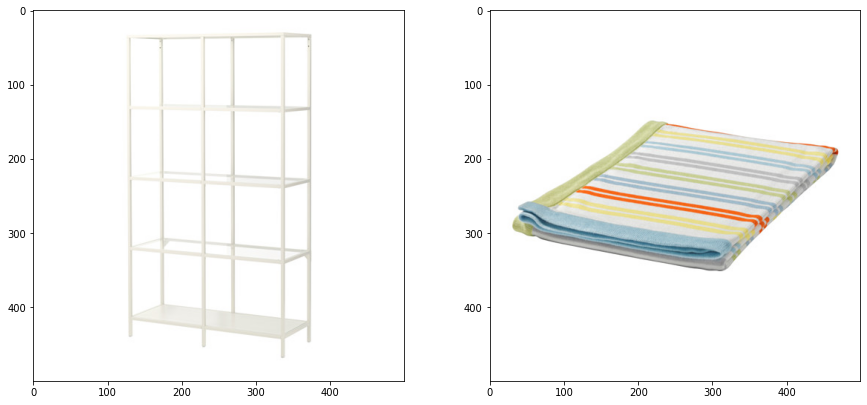

In [51]:
random_index = random.randint(0, len(train_pairs))
image_id_1 = train_pairs[random_index][0]
image_id_2 = train_pairs[random_index][1]
text_1 = train_premise_texts[random_index]
text_2 = train_hypothesis_texts[random_index]
prediction, confidence = single_pair_inference(premise_image_path=IMAGES_DIR + image_id_1 + ".jpg",
          hypothesis_image_path=IMAGES_DIR + image_id_2 + ".jpg",
          premise_text=text_1,
          hypothesis_text=text_2,
          model=model,
          tokenizer=tokenizer,
          threshold=0.4,
          do_plot=True)
print("Actual Label for this pair is", "Positive" if y_train[random_index] == 1 else "Negative")
print("The prediction for this pair is", prediction, "with confidence", confidence)

# Rank Evaluation

In [52]:
# Build pairs to rank
NUM_QUERIES = 50

val_products = sorted(list(set(x for pair in val_pairs for x in pair)))

np.random.seed(1234)
premise_products = np.random.choice(val_products, size=min(NUM_QUERIES, len(val_products)), replace=False)
hypothesis_products = val_products

ranking_pairs = list(itertools.product(premise_products, hypothesis_products))
print(len(ranking_pairs), "pairs,", len(hypothesis_products), "products per query")

35900 pairs, 718 products per query


In [53]:
# Get the ground-truth

ground_truth_map = {}
for item_url, room_url_list in item_to_rooms_map.items():
    item_id = item_url.split("/")[-1].split(".jpg")[0]
    if item_id not in premise_products: continue

    for room_url in room_url_list:
        room_id = room_url.split("/")[-1].split(".jpg")[0]
        ground_truth_map[item_id] = ground_truth_map.get(item_id, set()) | set(room_to_items[room_id])
ground_truth_lists = [ground_truth_map[item_id] for item_id in premise_products]


In [54]:
X_rank_image = FurnitureImagePairsDataset(IMAGES_DIR, ranking_pairs, np.zeros(len(ranking_pairs)))

X_rank_text_premise = [item_to_info[id] for id, _ in ranking_pairs]
X_rank_text_premise = tokenizer.texts_to_sequences(X_rank_text_premise)
X_rank_text_premise = pad_sequences(X_rank_text_premise, maxlen=MAX_SEQUENCE_LENGTH)

X_rank_text_hypothesis = [item_to_info[id] for _, id in ranking_pairs]
X_rank_text_hypothesis = tokenizer.texts_to_sequences(X_rank_text_hypothesis)
X_rank_text_hypothesis = pad_sequences(X_rank_text_hypothesis, maxlen=MAX_SEQUENCE_LENGTH)

100%|██████████| 718/718 [00:04<00:00, 167.39it/s]


In [55]:
img_ranking_data = X_rank_image
text_ranking_data = TensorDataset(torch.from_numpy(X_rank_text_premise), torch.from_numpy(X_rank_text_hypothesis), torch.zeros(len(ranking_pairs)))

text_ranking_loader = DataLoader(text_ranking_data, batch_size=BATCH_SIZE)
img_ranking_loader = DataLoader(img_ranking_data, batch_size=BATCH_SIZE)

print(len(text_ranking_loader), len(img_ranking_loader))

1122 1122


In [56]:
model.eval()
ranking_results = []
with torch.no_grad():
    for lstm, cnn in tqdm.tqdm(zip(text_ranking_loader, img_ranking_loader), total=len(text_ranking_loader)):
      lstm_inp1, lstm_inp2, _ = lstm
      cnn_inp1, cnn_inp2, _ = cnn
      lstm_inp1, lstm_inp2 = lstm_inp1.to(DEVICE), lstm_inp2.to(DEVICE)
      cnn_inp1, cnn_inp2 = cnn_inp1.to(DEVICE), cnn_inp2.to(DEVICE)
      model.zero_grad()
      output = model(lstm_inp1, lstm_inp2, cnn_inp1, cnn_inp2)
      score = output.squeeze().cpu().detach().numpy().tolist()
      ranking_results.append(score)
ranking_results = np.concatenate(ranking_results).reshape(len(premise_products), len(hypothesis_products))
print(ranking_results.shape)

100%|██████████| 1122/1122 [00:31<00:00, 35.90it/s]

(50, 718)


In [57]:
import math
class Evaluator:
    def __init__(self, GroundTruth):
      self.GroundTruth = GroundTruth

    def NDCG_Eval(self, rankresult, topk):
      sortedRankResult = sorted(rankresult.items(), key = lambda x:x[1], reverse=True)
      DCGScore = 0
      result = []
      for i, item in enumerate(sortedRankResult[:topk]):
        if item[0] in self.GroundTruth:
          result.append((item, i))
      DCGScore = sum([item[0][1]/math.log(item[1]+2, 2) for item in result])
      IDCGScore = sum([1/math.log(i+2,2) for i in range(topk)])
      NDCG = DCGScore / IDCGScore

      return NDCG
    
    def Score_Eval(self, rankresult, topk):
      sortedRankResult = sorted(rankresult.items(), key = lambda x:x[1], reverse=True)
      return sum(i[1] for i in sortedRankResult[:topk] if i[0] in self.GroundTruth) / topk
    
    def Precision(self, rankresult, topk):
      sortedRankResult = sorted(rankresult.items(), key = lambda x:x[1], reverse=True)
      topkresult = sortedRankResult[:topk]
      return len([i for i in sortedRankResult[:topk] if i[0] in self.GroundTruth]) / len(topkresult)

    def Recall(self, rankresult, topk):
      sortedRankResult = sorted(rankresult.items(), key = lambda x:x[1], reverse=True)
      topkresult = sortedRankResult[:topk]
      return len([i for i in sortedRankResult[:topk] if i[0] in self.GroundTruth]) / len(self.GroundTruth)
    
    def FValue(self, rankresult, topk):
      precision = self.Precision(rankresult, topk)
      recall = self.Recall(rankresult, topk)
      return 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

In [58]:
# Now use the evaluator
TOP_K = 10

ndcg = np.zeros(len(premise_products))
score = np.zeros(len(premise_products))
precision = np.zeros(len(premise_products))
recall = np.zeros(len(premise_products))
fvalue = np.zeros(len(premise_products))
for i, (ground_truth, rankings) in enumerate(zip(ground_truth_lists, ranking_results)):
    evaluator = Evaluator(ground_truth)
    rankings = {product: output for product, output in zip(hypothesis_products, rankings)}
    ndcg[i] = evaluator.NDCG_Eval(rankings, TOP_K)
    score[i] = evaluator.Score_Eval(rankings, TOP_K)
    precision[i] = evaluator.Precision(rankings, TOP_K)
    recall[i] = evaluator.Recall(rankings, TOP_K)
    fvalue[i] = evaluator.FValue(rankings, TOP_K)
print("NDCG: {:.4f} (95% CI {:.3f}-{:.3f})".format(ndcg.mean(), ndcg.mean() - 1.96 * ndcg.std(), ndcg.mean() + 1.96 * ndcg.std()))
print("Score: {:.4f} (95% CI {:.3f}-{:.3f})".format(score.mean(), score.mean() - 1.96 * score.std(), score.mean() + 1.96 * score.std()))
print("Precision: {:.4f} (95% CI {:.3f}-{:.3f})".format(precision.mean(), precision.mean() - 1.96 * precision.std(), precision.mean() + 1.96 * precision.std()))
print("Recall: {:.4f} (95% CI {:.3f}-{:.3f})".format(recall.mean(), recall.mean() - 1.96 * recall.std(), recall.mean() + 1.96 * recall.std()))
print("FValue: {:.4f} (95% CI {:.3f}-{:.3f})".format(fvalue.mean(), fvalue.mean() - 1.96 * fvalue.std(), fvalue.mean() + 1.96 * fvalue.std()))

NDCG: 0.0002 (95% CI -0.002-0.002)
Score: 0.0002 (95% CI -0.002-0.002)
Precision: 0.0060 (95% CI -0.041-0.053)
Recall: 0.0024 (95% CI -0.021-0.026)
FValue: 0.0031 (95% CI -0.024-0.030)
